In [1]:
# import keras
import fastai
from fastai.vision import *
# from fastai.metrics import fbeta, Precision, Recall, accuracy_thresh

In [2]:
fastai.__version__

'1.0.47'

In [80]:
import pandas as pd
import numpy as np

import os
import shutil
from pathlib import Path
import tarfile
import re

import matplotlib.pyplot as plt
from matplotlib.image import imread

from PIL import Image

In [4]:
path_data = Path('../data')

df_labs = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep='\t')

df_labs['file_name'] = df_labs['file_name'].str.replace('wav', 'png')

df_labs['subset'] = df_labs['file_name'].str.extract(r'([a-z]+)')
df_labs['subset'][df_labs['subset'] == 'devel'] = 'Valid'
df_labs['subset'][df_labs['subset'] == 'train'] = 'Train' 
df_labs['subset'][df_labs['subset'] == 'test'] = 'Test' 
# df_labs['subset'].value_counts()
df_labs.head()

,file_name,emotion,subset
0,train_0001.png,neutral,Train
1,train_0002.png,neutral,Train
2,train_0003.png,neutral,Train
3,train_0004.png,neutral,Train
4,train_0005.png,neutral,Train


In [167]:
print(df_labs.query('subset=="Valid"')['emotion'].value_counts())
# groupby('emotion').apply(sample)
print(df_labs['subset'].value_counts())

neutral    2024
happy       709
sad         234
angry        33
Name: emotion, dtype: int64
Train    3342
Valid    3000
Test      999
Name: subset, dtype: int64


In [100]:
file_names = df_labs.query('subset=="Test"')['file_name'].values
# imread('../data/spectogram/train_0001.png')
# x[:5]

In [107]:
read_image = lambda x: imread(f'../data/spectogram/{x}')
read_image = np.vectorize(read_image)
read_image(file_names)

ValueError: setting an array element with a sequence.

In [109]:
tfms = get_transforms()

# basic_block_test = (fastai.vision.ImageList
#                .from_df(path=path_data/'spectogram', df=df_labs.query('subset=="Test"'), cols='file_name')
#                .split_none()
#                .label_from_df(cols=1)
#               )

basic_block = (fastai.vision.ImageList
               .from_df(path=path_data/'spectogram', df=df_labs.query('subset!="Test"'), cols='file_name')
               .split_by_idx(valid_idx=df_labs.query('subset=="Valid"').index)
               .label_from_df(cols=1)
              )

db_speech = (basic_block
            .transform(tfms, 
                       size=64) 
            .databunch(bs=32))

db_speech.normalize(imagenet_stats)

# db_speech.export()



ImageDataBunch;

Train: LabelList (3342 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
neutral,neutral,neutral,neutral,neutral
Path: ../data/spectogram;

Valid: LabelList (3000 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
happy,happy,neutral,neutral,happy
Path: ../data/spectogram;

Test: None

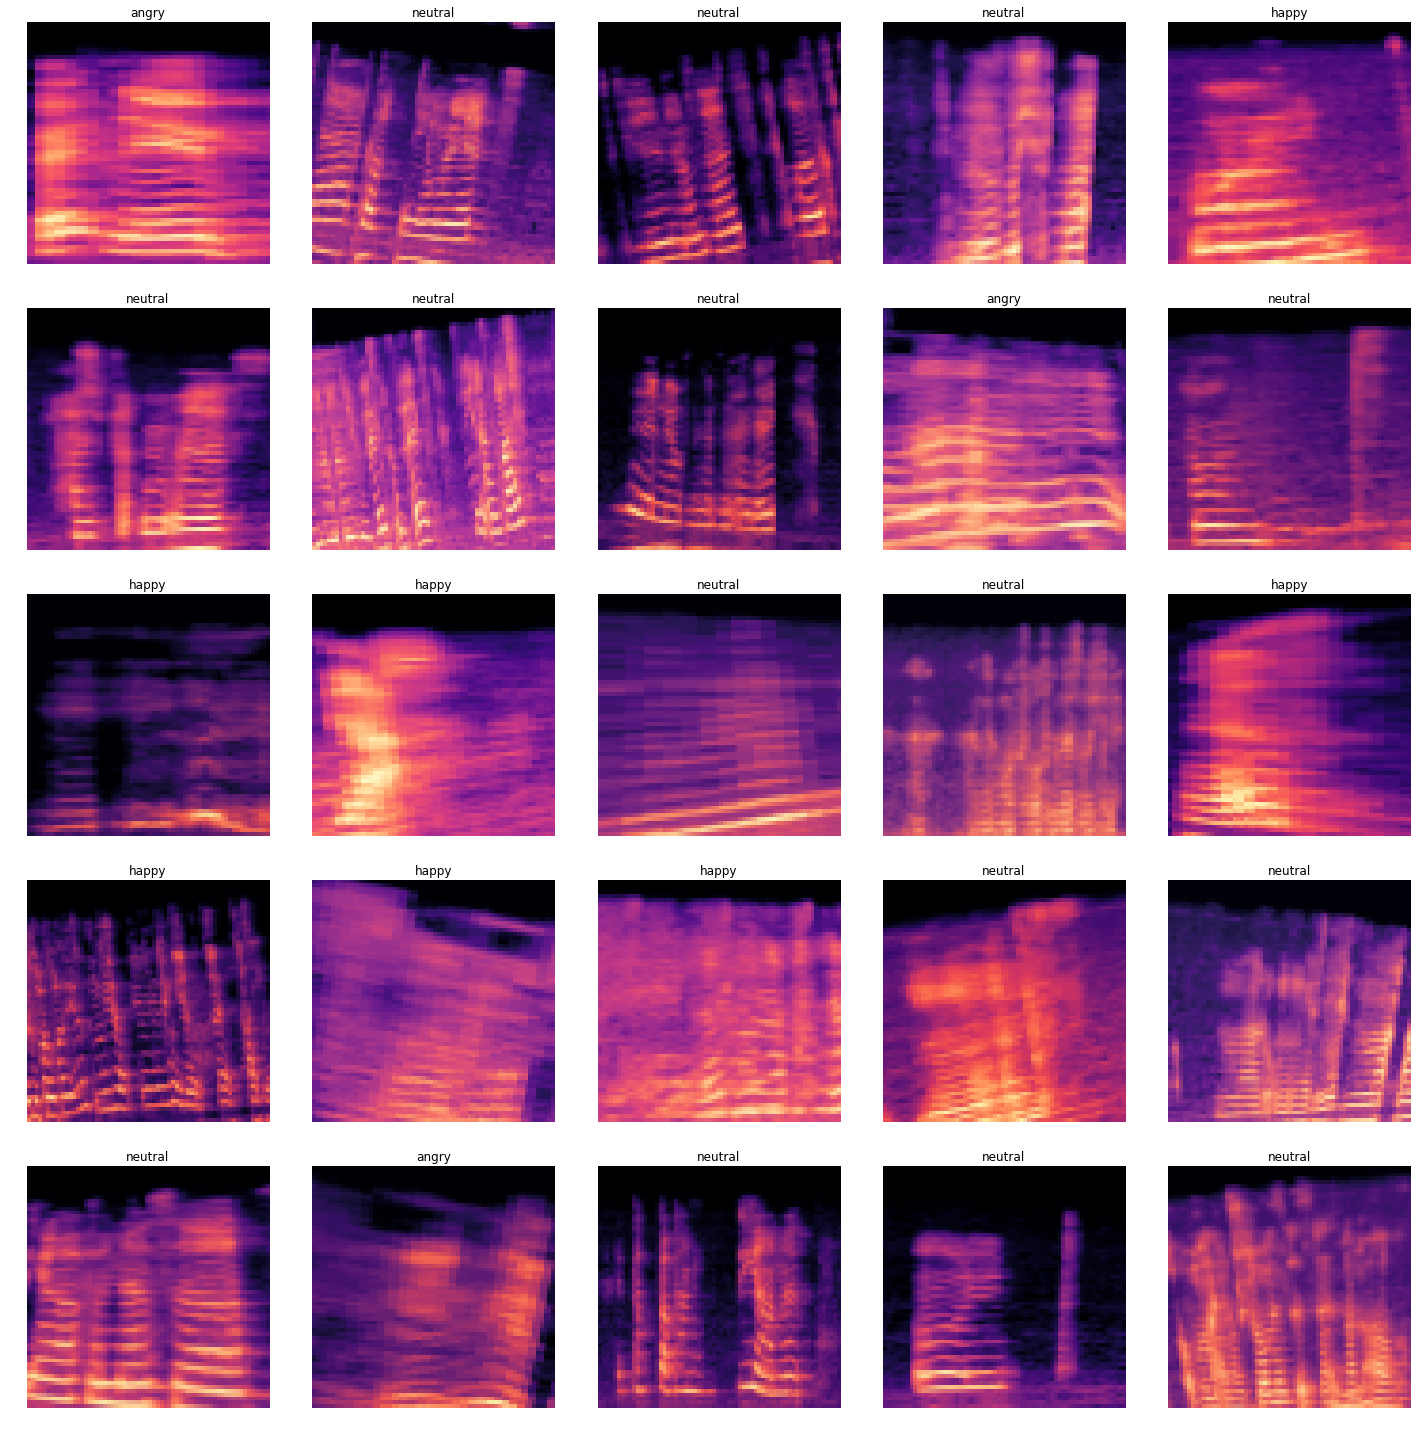

In [110]:
db_speech.show_batch()

In [111]:
model = cnn_learner(data=db_speech, 
                   base_arch=models.resnet34, 
                   metrics=[accuracy])

In [112]:
model.data.c, model.data.classes

(4, ['angry', 'happy', 'neutral', 'sad'])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


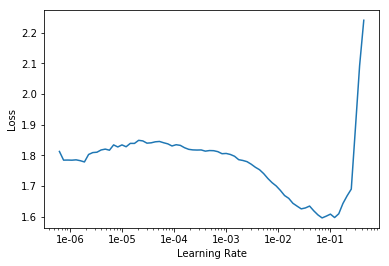

In [113]:
model.lr_find()
model.recorder.plot()

In [114]:
model.fit_one_cycle(cyc_len=5, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.182186,1.036379,0.664333,00:07
1,1.017117,1.016721,0.647333,00:07
2,0.922097,0.917116,0.651000,00:06
3,0.844719,0.929760,0.651667,00:06
4,0.807120,0.946545,0.643000,00:06


In [115]:
model.save('stage1')

In [116]:
model.load('stage1')
model.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


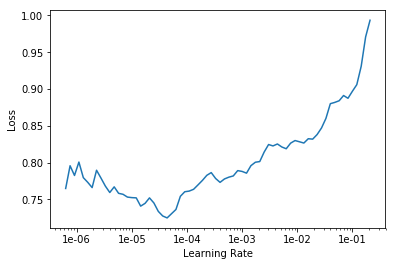

In [118]:
model.lr_find()
model.recorder.plot()

In [119]:
model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.779171,0.958605,0.642333,00:08
1,0.776089,0.927884,0.659000,00:08
2,0.756794,0.945699,0.652000,00:08
3,0.742659,0.906497,0.648667,00:08
4,0.718945,0.914911,0.646333,00:09


In [120]:
model.fit_one_cycle(cyc_len=5, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.723695,0.919045,0.650000,00:08
1,0.746698,0.921861,0.655667,00:08
2,0.710382,0.957946,0.625000,00:08
3,0.701041,0.928670,0.649000,00:08
4,0.697455,0.940691,0.637000,00:08


In [121]:
model.save('stage2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


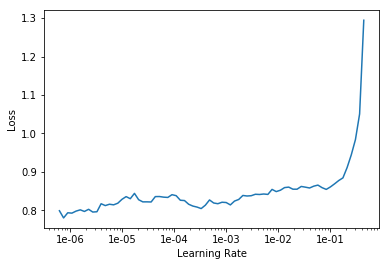

In [122]:
model.load('stage2')

model.data = (basic_block
            .transform(tfms, 
                       size=128) 
            .databunch(bs=64))

model.lr_find()
model.recorder.plot()

In [123]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(5e-4, 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.841061,1.220047,0.639667,00:12
1,0.858119,0.903430,0.675333,00:12
2,0.845231,0.990867,0.674333,00:12
3,0.805880,0.884857,0.678333,00:12
4,0.748907,0.890037,0.665000,00:12
5,0.709254,0.892056,0.676333,00:12


In [124]:
model.save('stage3')

In [125]:
model.load('stage3')

model.data = (basic_block
            .transform(tfms, 
                       size=170) 
            .databunch(bs=32))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


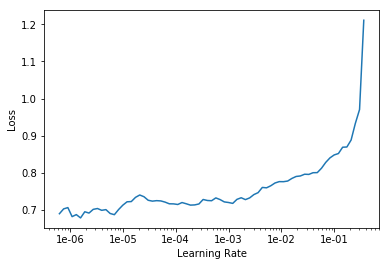

In [144]:
model.lr_find()
model.recorder.plot()

In [145]:
model.fit_one_cycle(cyc_len=6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.714485,0.912656,0.643000,00:21
1,0.718755,0.911626,0.641333,00:21
2,0.695958,0.891601,0.647333,00:21
3,0.685916,0.890697,0.645667,00:21
4,0.681152,0.896102,0.640333,00:21
5,0.688733,0.894957,0.645667,00:21


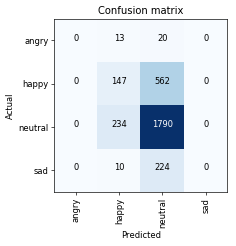

In [148]:
interp = ClassificationInterpretation.from_learner(model)

interp.plot_confusion_matrix(figsize=(4, 4), dpi=60)

In [150]:
interp.confusion_matrix().diagonal().sum()/interp.confusion_matrix().sum()

0.6456666666666667

In [146]:
x = ' '.join('''15 21 11 3
111 244 464 146
206 632 1496 508
13 22 152 142'''.split('\n'))
x = np.array([int(i) for i in x.split(' ')]).reshape(4,4)
print(x)
x.diagonal().sum()/x.sum()

[[  15   21   11    3]
 [ 111  244  464  146]
 [ 206  632 1496  508]
 [  13   22  152  142]]


0.4531772575250836

In [166]:
x.sum(), interp.confusion_matrix().sum()

(4186, 3000)